<a href="https://colab.research.google.com/github/bevislau/Data_Project/blob/main/Predicting_b2c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting B2C Visitor Purchases – Classification Modeling with BigQuery ML

This project applies a **binary classification model** using logistic regression to predict whether a B2B website visitor will convert into a customer. By analyzing user behavior data, the goal is to identify key factors that influence purchase intent and to build a predictive model that can support marketing and sales strategies.

In this case study, we use the **BigQuery ML public sample dataset** provided by Google:  
🔗 [BigQuery ML Templates Dataset](https://github.com/GoogleCloudPlatform/bigquery-ml-templates/tree/master/dataset)

The dataset captures behavioral signals from B2B visitors, such as session activity, engagement time, and visit source, which are leveraged to train the model and make predictions.

---

## 🔑 Key Steps in the Project

1. **Data Exploration & Preparation**  
   Understand the schema, clean the data, and define the target variable.

2. **Feature Engineering**  
   Derive meaningful behavioral features from raw logs to feed into the model.

3. **Model Creation**  
   Use logistic regression via BigQuery ML to build a classification model that predicts conversions.

4. **Model Evaluation**  
   Assess model performance using evaluation metrics like ROC AUC and precision-recall.

5. **Model Prediction**  
   Apply the trained model to predict user conversions for a selected day, informing future marketing activities.

6. **Recommendations & Next Steps**  
   Suggest ways to apply the model in real-world campaigns and propose future enhancements.


In [1]:
from google.colab import auth
auth.authenticate_user()

from google.cloud import bigquery
client = bigquery.Client(project='gifted-country-461816-i9')

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
from google.colab import auth
auth.authenticate_user()

# Then set your GCP project explicitly:
PROJECT_ID = "gifted-country-461816-i9"

# If you’re using %bigquery magic, set it like this:
%env GOOGLE_CLOUD_PROJECT=gifted-country-461816-i9

env: GOOGLE_CLOUD_PROJECT=gifted-country-461816-i9


# Data Exploration & Preparation

## Events data in GA4



In [3]:
query = """
SELECT event_name , COUNT(*)
FROM `gifted-country-461816-i9.ga4_sample_data.events_*`
GROUP BY event_name
ORDER BY COUNT(*) DESC

"""

df = client.query(query).to_dataframe()
display(df)

,event_name,f0_
0,page_view,1350428
1,user_engagement,1058721
2,scroll,493072
3,view_item,386068
4,session_start,354970
5,first_visit,257462
6,view_promotion,190104
7,add_to_cart,58543
8,begin_checkout,38757
9,select_item,31007


##Pearson Correlation with events

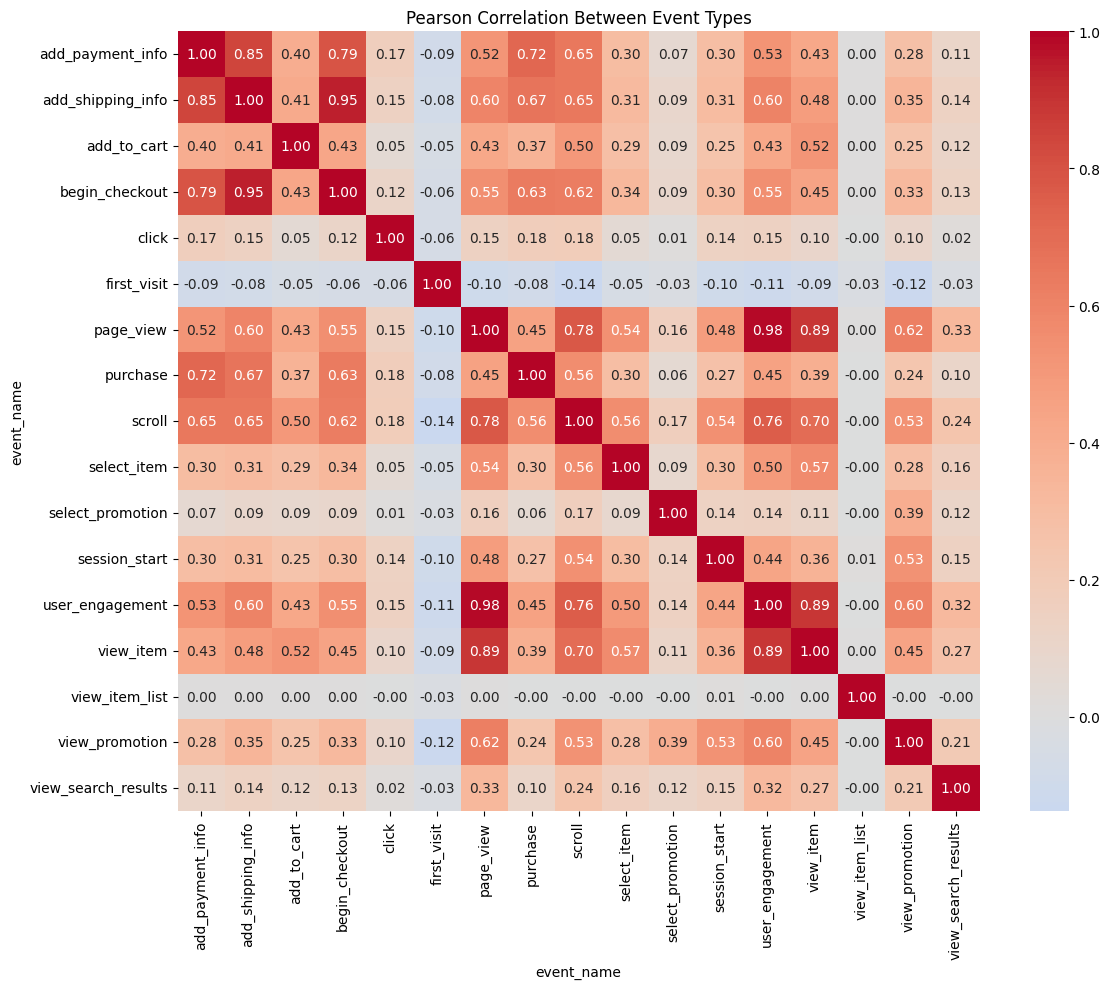

In [4]:
query = """
SELECT
  user_pseudo_id,
  event_name,
  COUNT(*) AS event_count
FROM
  `gifted-country-461816-i9.ga4_sample_data.events_*`
GROUP BY
  user_pseudo_id, event_name
ORDER BY COUNT(*) DESC
"""

df_raw = client.query(query).to_dataframe()

# Step 2: Pivot events into wide format (columns = event types)
df_pivot = df_raw.pivot_table(index='user_pseudo_id',
                               columns='event_name',
                               values='event_count',
                               fill_value=0)

# Step 3: Compute correlation matrix
corr_matrix = df_pivot.corr(method='pearson')

# Step 4: Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Pearson Correlation Between Event Types")
plt.tight_layout()
plt.show()

## User Demographics

In [5]:
query = """
SELECT geo.country,
COUNT(DISTINCT CONCAT(user_pseudo_id,event_bundle_sequence_id)) AS sessions_count ,
COUNT(DISTINCT user_pseudo_id) AS user_count ,
COUNT(DISTINCT CONCAT(user_pseudo_id,event_bundle_sequence_id))/COUNT(DISTINCT user_pseudo_id) AS Sessions_per_Users

FROM `gifted-country-461816-i9.ga4_sample_data.events_*`
GROUP BY geo.country
ORDER BY COUNT(DISTINCT CONCAT(user_pseudo_id,event_bundle_sequence_id)) DESC

"""

df = client.query(query).to_dataframe()
display(df)

,country,sessions_count,user_count,Sessions_per_Users
0,United States,1292954,118493,10.911649
1,India,264165,25367,10.413726
2,Canada,218765,20268,10.793616
3,United Kingdom,90148,8527,10.572065
4,Spain,55497,5044,11.002577
...,...,...,...,...
104,Oman,444,66,6.727273
105,Ghana,436,65,6.707692
106,Kosovo,369,53,6.962264
107,Honduras,349,51,6.843137


# Feature Engineering

To make it simply, we will predict whether the users are covnerted from first seesions and then use it to as an indication

Approach:

-Determine the first sessions users engaged with the website by MIN(event_timestamp) or user_first_touch_stamp

-Build the customer behaviour with events under multiple sessions or only 1

-Combine Behavioural and Demographics data with user_id for prediction

In [6]:
%%bigquery df --project gifted-country-461816-i9
---Find out the first sessions user visit
WITH first_time_user AS(
SELECT
  user_pseudo_id,
  MIN(event_timestamp) AS first_time,
  CONCAT(user_pseudo_id,MIN(event_timestamp)),
  COUNT(*)
FROM `gifted-country-461816-i9.ga4_sample_data.events_*`
WHERE event_name = 'page_view'
GROUP BY user_pseudo_id
)
--- Return 1 when user have the purchase in the same sessions
--- user_pseudo_id , label
--- WHERE: first sessions


SELECT
  CONCATE(user_pseudo_id,first_time),
  CASE WHEN event_name = 'Purchase' THEN 1 ELSE 0 END
FROM `gifted-country-461816-i9.ga4_sample_data.events_*` a
JOIN first_time_user ft ON
CONCAT(a.user_pseudo_id,MIN(a.event_timestamp)) = CONCAT(ft.user_pseudo_id,ft.first_time)




Executing query with job ID: 76d65f91-5219-4060-bb16-4212f4312466
Query executing: 0.67s


ERROR:
 400 Aggregate function MIN not allowed in JOIN ON clause at [22:25]; reason: invalidQuery, location: query, message: Aggregate function MIN not allowed in JOIN ON clause at [22:25]

Location: EU
Job ID: 76d65f91-5219-4060-bb16-4212f4312466



In [7]:
display(df)

QueryJob<project=gifted-country-461816-i9, location=EU, id=76d65f91-5219-4060-bb16-4212f4312466>

In [8]:
%%bigquery df --project gifted-country-461816-i9
SELECT
  user_pseudo_id,
  TIMESTAMP_MICROS(MIN(event_timestamp)) AS first_time,
  TIMESTAMP_MICROS(user_first_touch_timestamp)AS user_first_touch_timestamp
FROM `gifted-country-461816-i9.ga4_sample_data.events_*`
WHERE event_name = 'page_view'
GROUP BY user_pseudo_id,TIMESTAMP_MICROS(user_first_touch_timestamp)
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

In [9]:
display(df)

,user_pseudo_id,first_time,user_first_touch_timestamp
0,1081999.3309921012,2021-01-23 12:12:17.167609+00:00,2021-01-23 12:12:17.167609+00:00
1,1098594.2055393860,2021-01-23 06:48:30.748590+00:00,2021-01-23 06:48:30.748590+00:00
2,1142185.8369847719,2021-01-23 16:29:10.753020+00:00,2021-01-23 16:29:10.753020+00:00
3,1201375.2488291239,2021-01-23 14:21:11.656296+00:00,2021-01-23 14:21:11.656296+00:00
4,1253716.8874249704,2021-01-23 23:49:07.181262+00:00,2021-01-23 23:49:07.181262+00:00
5,1287991.9878305920,2021-01-23 04:26:20.777022+00:00,2021-01-23 04:26:20.777022+00:00
6,1323570.4117774243,2021-01-23 09:32:30.361875+00:00,2021-01-23 09:32:30.361875+00:00
7,1406007.4609789626,2021-01-05 01:54:43.815678+00:00,2020-10-29 08:09:41.430215+00:00
8,1432095.1099129988,2021-01-23 08:39:43.550395+00:00,2021-01-23 08:39:43.550395+00:00
9,1627421.9435168453,2021-01-23 02:01:42.723009+00:00,2021-01-23 02:01:42.723009+00:00


From the result, we can confirm the event_timestamp would equal to user_first_touch_timestamp if this is the first time customer enter the site

In GA4, the typical approach will be to combine User pseudo id with Sessions id to find the earliest and we would consider consent status as well


In [10]:
%%bigquery df --project gifted-country-461816-i9
---first sessions start time
SELECT
    user_pseudo_id,
    (SELECT value.int_value
     FROM UNNEST(event_params)
     WHERE key = 'ga_session_id' ) AS session_id,
    MIN(event_timestamp) AS session_start_time,
    user_first_touch_timestamp
  FROM `gifted-country-461816-i9.ga4_sample_data.events_*`
  WHERE event_name = 'page_view'
  GROUP BY user_pseudo_id, session_id,user_first_touch_timestamp
  ORDER BY session_start_time ASC

Query is running:   0%|          |

Downloading:   0%|          |

In [11]:
display(df)

,user_pseudo_id,session_id,session_start_time,user_first_touch_timestamp
0,82023966.6010891291,1090192382,1604188804579566,1604188804579566
1,7754124.2052719725,3291659989,1604188806427147,1604188806427147
2,50214262.5614106866,9011333152,1604188827483279,1604188827483279
3,7659668.5428867508,9613106892,1604188854567876,1604188854567876
4,29567946.8663048399,9050632539,1604188882314163,1604188882314163
...,...,...,...,...
333678,68089786.6365688416,1777527215,1612137456930837,1612137456930837
333679,13383964.1447354135,6195578290,1612137538186128,1612137538186128
333680,26585534.8676607659,598855204,1612137552596664,<NA>
333681,1299518.4337551586,3213054916,1612137580397192,1612137580397192


In [12]:
%%bigquery df --project gifted-country-461816-i9
---Step 1: Find out the first sessions user visit period
---Step 2: ues the WHERE clause, only include those first sessions, and count the event

WITH first_time_sessions AS(
SELECT
  CONCAT(user_pseudo_id,
  (SELECT value.int_value FROM UNNEST(event_params) where key = 'ga_session_id')
  ) AS first_user_id_and_session
FROM `gifted-country-461816-i9.ga4_sample_data.events_*`
WHERE event_name = 'page_view' AND event_timestamp = user_first_touch_timestamp
)

SELECT
m.user_pseudo_id,
COUNTIF(event_name = 'page_view') AS page_view_count,
COUNTIF(event_name = 'view_item') AS view_item_count,
COUNTIF(event_name = 'add_to_cart') AS add_to_cart_count,
COUNTIF(event_name = 'scroll') AS scroll_count,
FROM `gifted-country-461816-i9.ga4_sample_data.events_*` m
JOIN first_time_sessions f
ON CONCAT(m.user_pseudo_id,
  (SELECT value.int_value FROM UNNEST(event_params) where key = 'ga_session_id')
  )  = f.first_user_id_and_session
GROUP BY m.user_pseudo_id
ORDER BY page_view_count DESC,view_item_count DESC,add_to_cart_count DESC,scroll_count DESC



Query is running:   0%|          |

Downloading:   0%|          |

In [13]:
display(df)

,user_pseudo_id,page_view_count,view_item_count,add_to_cart_count,scroll_count
0,23345428.2948094181,566,112,0,32
1,49972222.2824139250,411,176,0,64
2,8122062.7957560873,230,0,0,0
3,45732822.6958771748,201,136,27,113
4,2023035.6131522592,199,125,8,144
...,...,...,...,...,...
256877,85647154.6184807353,1,0,0,0
256878,86913011.4478016354,1,0,0,0
256879,89419588.7637077468,1,0,0,0
256880,1503449970.2740766929,1,0,0,0



### Double check the work from the above for the highest activity user

In [14]:
%%bigquery df --project gifted-country-461816-i9
---Double check the work from the above for the highest activity user

WITH first_time_sessions AS(
SELECT
  CONCAT(user_pseudo_id,
  (SELECT value.int_value FROM UNNEST(event_params) where key = 'ga_session_id')
  ) AS first_user_id_and_session
FROM `gifted-country-461816-i9.ga4_sample_data.events_*`
WHERE event_name = 'page_view' AND event_timestamp = user_first_touch_timestamp
)

SELECT
m.user_pseudo_id,
event_name,
(SELECT value.int_value FROM UNNEST(event_params) where key = 'ga_session_id')
FROM `gifted-country-461816-i9.ga4_sample_data.events_*` m
JOIN first_time_sessions f
ON CONCAT(m.user_pseudo_id,
  (SELECT value.int_value FROM UNNEST(event_params) where key = 'ga_session_id')
  )  = f.first_user_id_and_session
WHERE m.user_pseudo_id = '23345428.2948094181'

Query is running:   0%|          |

Downloading:   0%|          |

In [15]:
display(df)

,user_pseudo_id,event_name,f0_
0,23345428.2948094181,page_view,5100763476
1,23345428.2948094181,page_view,5100763476
2,23345428.2948094181,view_search_results,5100763476
3,23345428.2948094181,page_view,5100763476
4,23345428.2948094181,page_view,5100763476
...,...,...,...
734,23345428.2948094181,view_promotion,5100763476
735,23345428.2948094181,view_promotion,5100763476
736,23345428.2948094181,view_promotion,5100763476
737,23345428.2948094181,view_promotion,5100763476


## To consider more than ther first sessions behaviour, we start ranking the sessions and gather the user behaviour

In [16]:
%%bigquery df --project gifted-country-461816-i9
-- with first_session start time
WITH session_start_times AS (
  SELECT
    user_pseudo_id,
    (SELECT value.int_value FROM UNNEST(event_params) WHERE key = 'ga_session_id') AS session_id,
    MIN(event_timestamp) AS session_start_time
  FROM `gifted-country-461816-i9.ga4_sample_data.events_*`
  WHERE event_name = 'page_view'
  GROUP BY user_pseudo_id, session_id

),

-- Rank sessions by time per user
ranked_sessions AS (
  SELECT
    user_pseudo_id,
    session_id,
    session_start_time,
    RANK() OVER (PARTITION BY user_pseudo_id ORDER BY session_start_time ASC) AS session_rank
  FROM session_start_times
)

-- Get only second session or LESS
SELECT *
FROM ranked_sessions
WHERE session_rank <= 2
ORDER BY user_pseudo_id ,session_rank ASC



Query is running:   0%|          |

Downloading:   0%|          |

In [17]:
display(df)

,user_pseudo_id,session_id,session_start_time,session_rank
0,10001363.4360935308,5983736405,1607746277508078,1
1,1000223163.8035209215,6063162078,1610044534089387,1
2,1000299.7413851356,3338398581,1611140699887247,1
3,1000300.3223254235,9350310735,1604481671657014,1
4,10003031.4607645453,699335171,1607707512071831,1
...,...,...,...,...
304383,9997317.3571391655,706568855,1609817608977517,2
304384,99974675.1893931687,653531931,1604610066461822,1
304385,9997700.2258881857,9749273419,1611611230828176,1
304386,99978280.9164065304,4614501286,1607462806387509,1


In [18]:
%%bigquery df --project gifted-country-461816-i9
-- with first_session start time
WITH session_start_times AS (
  SELECT
    user_pseudo_id,
    (SELECT value.int_value FROM UNNEST(event_params) WHERE key = 'ga_session_id') AS session_id,
    MIN(event_timestamp) AS session_start_time
  FROM `gifted-country-461816-i9.ga4_sample_data.events_*`
  WHERE event_name = 'page_view'
  GROUP BY user_pseudo_id, session_id

),

-- Rank sessions by time per user
ranked_sessions AS (
  SELECT
    user_pseudo_id,
    session_id,
    session_start_time,
    RANK() OVER (PARTITION BY user_pseudo_id ORDER BY session_start_time ASC) AS session_rank
  FROM session_start_times
),

user_firsttwo_sessions AS(
-- Get only second session or less
SELECT *
FROM ranked_sessions
WHERE session_rank <= 2
ORDER BY user_pseudo_id ,session_rank ASC
)

SELECT
m.user_pseudo_id,
COUNTIF(event_name = 'page_view') AS page_view_count,
COUNTIF(event_name = 'view_item') AS view_item_count,
COUNTIF(event_name = 'add_to_cart') AS add_to_cart_count,
COUNTIF(event_name = 'scroll') AS scroll_count,
SUM(CAST((SELECT value.int_value
            FROM UNNEST(event_params)
            WHERE key = 'engagement_time_msec') AS INT64)) AS total_engagement_time_msec,
CASE WHEN (COUNTIF (event_name = 'purchase') >= 1 ) THEN 1 ELSE 0 END AS will_buy_on_firsttwo_Sessions
FROM `gifted-country-461816-i9.ga4_sample_data.events_*` m
JOIN user_firsttwo_sessions f
ON (SELECT value.int_value FROM UNNEST(event_params) where key = 'ga_session_id')
  = f.session_id
GROUP BY m.user_pseudo_id
ORDER BY will_buy_on_firsttwo_Sessions DESC , page_view_count DESC,view_item_count DESC,add_to_cart_count DESC,scroll_count DESC



Query is running:   0%|          |

Downloading:   0%|          |

In [19]:
display(df)

,user_pseudo_id,page_view_count,view_item_count,add_to_cart_count,scroll_count,total_engagement_time_msec,will_buy_on_firsttwo_Sessions
0,4096423.2647740834,415,187,3,101,9361392,1
1,27314189.0356814830,311,155,30,87,7363024,1
2,3030394.7459625087,307,134,0,111,5752446,1
3,4777652.2980568851,286,147,27,105,7083995,1
4,3198843.0611848527,267,235,122,146,7386138,1
...,...,...,...,...,...,...,...
269801,4112323.2313540690,0,0,0,0,<NA>,0
269802,27398094.8921216869,0,0,0,0,<NA>,0
269803,4201418.0822426379,0,0,0,0,2408,0
269804,4080246.8182959576,0,0,0,0,<NA>,0


## Comparsion with purchaser and non-purchasesr under 2 sessions

In [20]:
%%bigquery df --project gifted-country-461816-i9
-- with first_session start time
WITH session_start_times AS (
  SELECT
    user_pseudo_id,
    (SELECT value.int_value FROM UNNEST(event_params) WHERE key = 'ga_session_id') AS session_id,
    MIN(event_timestamp) AS session_start_time
  FROM `gifted-country-461816-i9.ga4_sample_data.events_*`
  WHERE event_name = 'page_view'
  GROUP BY user_pseudo_id, session_id

),

-- Rank sessions by time per user
ranked_sessions AS (
  SELECT
    user_pseudo_id,
    session_id,
    session_start_time,
    RANK() OVER (PARTITION BY user_pseudo_id ORDER BY session_start_time ASC) AS session_rank
  FROM session_start_times
),

user_firsttwo_sessions AS(
-- Get only second session or less
SELECT *
FROM ranked_sessions
WHERE session_rank <= 2
ORDER BY user_pseudo_id ,session_rank ASC
),

user_profiling AS(
SELECT
m.user_pseudo_id,
COUNTIF(event_name = 'page_view') AS page_view_count,
COUNTIF(event_name = 'view_item') AS view_item_count,
COUNTIF(event_name = 'add_to_cart') AS add_to_cart_count,
COUNTIF(event_name = 'scroll') AS scroll_count,
CASE WHEN (COUNTIF (event_name = 'purchase') >= 1 ) THEN 1 ELSE 0 END AS will_buy_on_firsttwo_Sessions
FROM `gifted-country-461816-i9.ga4_sample_data.events_*` m
JOIN user_firsttwo_sessions f
ON (SELECT value.int_value FROM UNNEST(event_params) where key = 'ga_session_id')
  = f.session_id
GROUP BY m.user_pseudo_id
ORDER BY will_buy_on_firsttwo_Sessions DESC , page_view_count DESC,view_item_count DESC,add_to_cart_count DESC,scroll_count DESC
)

SELECT will_buy_on_firsttwo_Sessions, COUNT(*)
FROM user_profiling
GROUP BY will_buy_on_firsttwo_Sessions


Query is running:   0%|          |

Downloading:   0%|          |

In [21]:
display(df)

,will_buy_on_firsttwo_Sessions,f0_
0,0,266559
1,1,3247


### From the result, the % of purchaser is 3247/(266559+3247) = 1.2% purchasers.

### As the % purchasesr is quiet low, i have go ahead and widen the criteria with the sessions to 4

## Comparsion with purchaser and non-purchasesr under 4 sessions

In [22]:
%%bigquery df --project gifted-country-461816-i9
-- with first_session start time
WITH session_start_times AS (
  SELECT
    user_pseudo_id,
    (SELECT value.int_value FROM UNNEST(event_params) WHERE key = 'ga_session_id') AS session_id,
    MIN(event_timestamp) AS session_start_time
  FROM `gifted-country-461816-i9.ga4_sample_data.events_*`
  WHERE event_name = 'page_view'
  GROUP BY user_pseudo_id, session_id

),

-- Rank sessions by time per user
ranked_sessions AS (
  SELECT
    user_pseudo_id,
    session_id,
    session_start_time,
    RANK() OVER (PARTITION BY user_pseudo_id ORDER BY session_start_time ASC) AS session_rank
  FROM session_start_times
),

user_firsttwo_sessions AS(
-- Get only second session or less
SELECT *
FROM ranked_sessions
WHERE session_rank <= 4
ORDER BY user_pseudo_id ,session_rank ASC
),

user_profiling AS(
SELECT
m.user_pseudo_id,
COUNTIF(event_name = 'page_view') AS page_view_count,
COUNTIF(event_name = 'view_item') AS view_item_count,
COUNTIF(event_name = 'add_to_cart') AS add_to_cart_count,
COUNTIF(event_name = 'user_engagement') AS user_engagement_count,
COUNTIF(event_name = 'scroll') AS scroll_count,
CASE WHEN (COUNTIF (event_name = 'purchase') >= 1 ) THEN 1 ELSE 0 END AS will_buy_on_firstfour_Sessions
FROM `gifted-country-461816-i9.ga4_sample_data.events_*` m
JOIN user_firsttwo_sessions f
ON (SELECT value.int_value FROM UNNEST(event_params) where key = 'ga_session_id')
  = f.session_id
GROUP BY m.user_pseudo_id
)

SELECT will_buy_on_firstfour_Sessions, COUNT(*)
FROM user_profiling
GROUP BY will_buy_on_firstfour_Sessions


Query is running:   0%|          |

Downloading:   0%|          |

In [23]:
display(df)

,will_buy_on_firstfour_Sessions,f0_
0,0,265737
1,1,4069


## From the result, the % of purchaser is higher 4069/ (265737+4069) = 1.51% purchasers.

# Model Creation

From the initial feature engineering, there are less behavioural data planned and later the model has been further fine-tuned


### 🎯 Label:
- `label`: 1 if the user triggered a **purchase event** in their first 4 sessions, 0 otherwise.

### 🧠 Features used for prediction:

#### 🧍‍♂️ User Behavior:
- `page_view_count`
- `view_item_count`
- `scroll_count`
- `user_engagement_count`
- `add_to_cart_count`
- `view_promotion_count`
- `total_engagement_time_msec` (New)

#### 🌍 Demographics & Technology:
- `device_category` (e.g., desktop, mobile) (New)
- `country` (geo-location during first session) (New)
- Unforunately we cannot include channel and source and medium as it is hiddne in the sample data

👉 Users with no `view_item`, `page_view`` activity were excluded to focus on **meaningfully engaged users**.

In [24]:
%%bigquery df --project gifted-country-461816-i9

CREATE OR REPLACE TABLE `gifted-country-461816-i9.ga4_sample_data.ml_prepareddata` AS (

WITH events_flat AS (
  SELECT
    user_pseudo_id,
    event_timestamp,
    (SELECT value.int_value
     FROM UNNEST(event_params)
     WHERE key = 'ga_session_id' LIMIT 1) AS session_id
  FROM
    `gifted-country-461816-i9.ga4_sample_data.events_*`
  WHERE
    event_name = 'page_view'
),

-- One row per session per user, with session start time
session_start_times AS (
  SELECT
    user_pseudo_id,
    session_id,
    MIN(event_timestamp) AS session_start_time
  FROM events_flat
  WHERE session_id IS NOT NULL
  GROUP BY user_pseudo_id, session_id
),

-- Rank sessions by time per user
ranked_sessions AS (
  SELECT
    user_pseudo_id,
    session_id,
    session_start_time,
    RANK() OVER (PARTITION BY user_pseudo_id ORDER BY session_start_time ASC) AS session_rank
  FROM session_start_times
),

user_firsttwo_sessions AS(
-- Get only second session or less
SELECT *
FROM ranked_sessions
WHERE session_rank <=4
ORDER BY user_pseudo_id ,session_rank ASC
),
user_metadata AS (
  SELECT
    user_pseudo_id,
    device.category AS device_category,
    geo.country AS country
  FROM (
    SELECT *,
      RANK() OVER (PARTITION BY user_pseudo_id ORDER BY event_timestamp ASC) AS session_rank
    FROM `gifted-country-461816-i9.ga4_sample_data.events_*`
    WHERE event_name = 'session_start'
  )
  WHERE session_rank = 1
)

SELECT
m.user_pseudo_id,
--Behavioural data
COUNTIF(event_name = 'page_view') AS page_view_count,
COUNTIF(event_name = 'view_item') AS view_item_count,
COUNTIF(event_name = 'scroll') AS scroll_count,
COUNTIF(event_name = 'user_engagement') AS user_engagement_count,
COUNTIF(event_name = 'add_to_cart') AS add_to_cart_count,
COUNTIF(event_name = 'view_promotion') AS view_promotion_count,
SUM(CAST((SELECT value.int_value
            FROM UNNEST(event_params)
            WHERE key = 'engagement_time_msec') AS INT64)) AS total_engagement_time_msec,
--demographic
  um.device_category AS device_category,
  um.country AS country,

--label
CASE WHEN (COUNTIF (event_name = 'purchase') >= 1 ) THEN 1 ELSE 0 END AS label
FROM `gifted-country-461816-i9.ga4_sample_data.events_*` m
JOIN user_firsttwo_sessions f
ON (SELECT value.int_value FROM UNNEST(event_params) where key = 'ga_session_id')
  = f.session_id
LEFT JOIN user_metadata um
ON  m.user_pseudo_id = um.user_pseudo_id
GROUP BY m.user_pseudo_id,um.device_category, um.country
HAVING view_item_count > 0 AND page_view_count > 0
)



Query is running:   0%|          |

In [25]:
%%bigquery df --project gifted-country-461816-i9

CREATE OR REPLACE MODEL `gifted-country-461816-i9.ga4_sample_data.model`
OPTIONS(
  model_type='logistic_reg',
  auto_class_weights=TRUE,
  input_label_cols=['label']
)
AS
SELECT
  page_view_count,
  view_item_count,
  scroll_count,
  add_to_cart_count,
  total_engagement_time_msec,
  user_engagement_count,
  view_promotion_count,
  device_category,
  country,
  label
FROM `gifted-country-461816-i9.ga4_sample_data.ml_prepareddata`

Query is running:   0%|          |

# Model Evaluation

In [26]:
%%bigquery df --project gifted-country-461816-i9

SELECT *
FROM ML.EVALUATE(
  MODEL `gifted-country-461816-i9.ga4_sample_data.model`)

Query is running:   0%|          |

Downloading:   0%|          |

In [27]:
display(df)

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.594356,0.655642,0.826809,0.623497,0.452702,0.8737


## 📊 Model Evaluation Results

| Metric       | Value   |
|--------------|---------|
| Precision    | 0.5944  |
| Recall       | 0.6556  |
| Accuracy     | 0.8268  |
| F1 Score     | 0.6235  |
| Log Loss     | 0.4527  |
| ROC AUC      | 0.8737  |

---

### 🔍 Key Takeaways:
✅ **High Accuracy (83%)**  
> Most predictions are correct (Both Positive and Negatives). Strong generalisation

⚖️ **Balanced Precision & Recall**  
> Captures ~66% of purchasers (recall), and 59% of positive predictions are correct (precision).
> Recall shows we are able to find purchasers better, while maybe less as precision to get it right
> Work further to obtain a higher precision and recall

✅ **Strong ROC AUC (0.87)**  
> The model does a great job ranking likely purchasers — it is likely to rank a real buyer higher than non-buyer.
ideal for targeting and prioritisation.

🔁 **Improved F1 Score (~0.62)**  
> Indicates a fair balance between false positives and false negatives.


#Model Prediction

In [28]:
query = """
CREATE OR REPLACE TABLE `gifted-country-461816-i9.ga4_sample_data.model_predictions` AS
SELECT
  predicted_label,
  label
FROM
  ML.PREDICT(
    MODEL `gifted-country-461816-i9.ga4_sample_data.model`,
    TABLE `gifted-country-461816-i9.ga4_sample_data.ml_prepareddata`
  )

"""

# Run the query
query_job = client.query(query)
query_job.result()  # Wait for job to finish
print("Table created successfully.")

Table created successfully.


In [29]:
query = """
SELECT predicted_label, label
FROM `gifted-country-461816-i9.ga4_sample_data.model_predictions`
"""
df = client.query(query).to_dataframe()

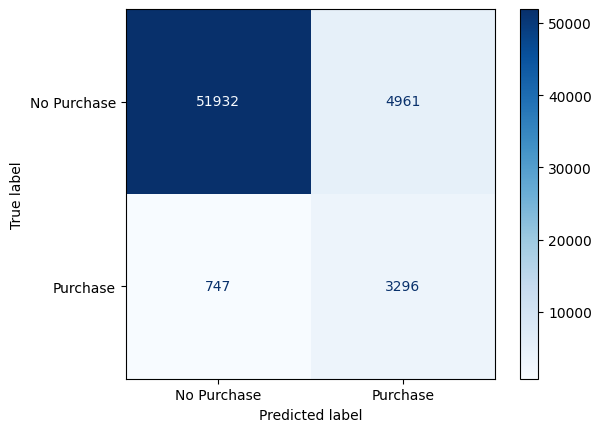

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Ensure data is in int format
y_true = df['label'].astype(int)
y_pred = df['predicted_label'].astype(int)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display it with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Purchase", "Purchase"])
disp.plot(cmap='Blues')

In [31]:
%%bigquery df --project gifted-country-461816-i9


SELECT
  user_pseudo_id,
  page_view_count,
  view_item_count,
  scroll_count,
  user_engagement_count,
  view_promotion_count,
  total_engagement_time_msec,
  device_category,
  country,
  predicted_label,
  predicted_label_probs[SAFE_OFFSET(1)].prob AS purchase_probability

FROM ML.PREDICT(
  MODEL `gifted-country-461816-i9.ga4_sample_data.model`,
  (
    -- New customers feature data here, e.g. last day (20210131)
WITH events_flat AS (
  SELECT
    user_pseudo_id,
    event_timestamp,
    (SELECT value.int_value
     FROM UNNEST(event_params)
     WHERE key = 'ga_session_id' LIMIT 1) AS session_id
  FROM
    `gifted-country-461816-i9.ga4_sample_data.events_*`
  WHERE
    event_name = 'page_view'
    AND _table_suffix = '20210131'
),

-- One row per session per user, with session start time
session_start_times AS (
  SELECT
    user_pseudo_id,
    session_id,
    MIN(event_timestamp) AS session_start_time
  FROM events_flat
  WHERE session_id IS NOT NULL
  GROUP BY user_pseudo_id, session_id
),

-- Rank sessions by time per user
ranked_sessions AS (
  SELECT
    user_pseudo_id,
    session_id,
    session_start_time,
    RANK() OVER (PARTITION BY user_pseudo_id ORDER BY session_start_time ASC) AS session_rank
  FROM session_start_times
),

user_firsttwo_sessions AS(
SELECT *
FROM ranked_sessions
WHERE session_rank <=4 -- Get only 4 session or less
ORDER BY user_pseudo_id ,session_rank ASC
),
user_metadata AS (
  SELECT
    user_pseudo_id,
    device.category        AS device_category,
    geo.country            AS country
  FROM (
    SELECT *,
      RANK() OVER (PARTITION BY user_pseudo_id ORDER BY event_timestamp ASC) AS session_rank
    FROM `gifted-country-461816-i9.ga4_sample_data.events_*`
    WHERE event_name = 'session_start'
  )
  WHERE session_rank = 1
)

SELECT
m.user_pseudo_id,
--Behavioural data
COUNTIF(event_name = 'page_view') AS page_view_count,
COUNTIF(event_name = 'view_item') AS view_item_count,
COUNTIF(event_name = 'scroll') AS scroll_count,
COUNTIF(event_name = 'user_engagement') AS user_engagement_count,
COUNTIF(event_name = 'add_to_cart') AS add_to_cart_count,
COUNTIF(event_name = 'view_promotion') AS view_promotion_count,
SUM(CAST((SELECT value.int_value
            FROM UNNEST(event_params)
            WHERE key = 'engagement_time_msec') AS INT64)) AS total_engagement_time_msec,
--demographic
  um.device_category AS device_category,
  um.country AS country,

--label
CASE WHEN (COUNTIF (event_name = 'purchase') >= 1 ) THEN 1 ELSE 0 END AS label
FROM `gifted-country-461816-i9.ga4_sample_data.events_*` m
JOIN user_firsttwo_sessions f
ON (SELECT value.int_value FROM UNNEST(event_params) where key = 'ga_session_id')
  = f.session_id
LEFT JOIN user_metadata um
ON  m.user_pseudo_id = um.user_pseudo_id
GROUP BY m.user_pseudo_id,um.device_category, um.country

  )
)

ORDER BY predicted_label DESC , purchase_probability DESC


Query is running:   0%|          |

Downloading:   0%|          |

In [32]:
display(df)

,user_pseudo_id,page_view_count,view_item_count,scroll_count,user_engagement_count,view_promotion_count,total_engagement_time_msec,device_category,country,predicted_label,purchase_probability
0,5146751.2449405377,21,16,7,16,2,551480,desktop,Australia,1,0.489968
1,89239732.9202250717,17,13,10,13,0,1119894,desktop,United States,1,0.479603
2,6074851.0215267688,6,2,5,4,2,1335025,mobile,France,1,0.479424
3,83297829.2529898907,26,8,13,27,2,742151,desktop,Sweden,1,0.479178
4,31221572.8286569024,26,6,7,0,0,455868,desktop,Canada,1,0.460712
...,...,...,...,...,...,...,...,...,...,...,...
2515,69064877.5854121514,22,7,12,17,1,269575,desktop,United States,0,0.559887
2516,1617434.1535145542,15,7,7,10,1,177557,mobile,Singapore,0,0.553646
2517,8212764327.9724632131,24,11,16,18,4,193429,mobile,Croatia,0,0.533630
2518,6037143.3698637442,11,0,10,11,0,540863,desktop,United States,0,0.518794


#Recommendations & Next Steps

### 🎯 Model Refinement
- **Tune the classification threshold** (not just 0.5) to better balance precision and recall depending on your business objective (e.g. acquisition vs retention).
- **Reweight classes** to account for class imbalance (e.g. <2% of users made a purchase), improving the model’s sensitivity to rare events.

---

### 🧠 Feature Refinement
- **Normalise or log-transform** `total_engagement_time_msec` to reduce skew and improve model fit.
- **Create interaction features** such as `view_item_count * engagement_time` to capture user intensity.
- **Bin features** like `add_to_cart_count` into tiers to model behavioural stages (e.g. low, medium, high intent).
- **Integrate CRM tags or loyalty programme signals** to enrich understanding of customer type.

---

### ➕ Add More Contextual Features
- **Include digital marketing attributes** such as `traffic_source.medium`, `traffic_source.source`, and `utm_campaign` for acquisition insights. *(Note: not available in the current sample dataset.)*
- **Add session-level temporal features** such as `day_of_week`, `hour_of_day`, or `session_duration`.

---

### 🔄 Segment-Specific Modelling
- Train separate models by key segments such as:
  - `device.category` (e.g. mobile vs desktop)
  - `geo.country` or `geo.region`
- This captures behavioural nuances that may differ significantly across user cohorts.

---

### 📈 Business Applications
Leverage model predictions to drive real-world value:
- **Trigger remarketing campaigns** or personalised email sequences.
- **Tailor homepage/product suggestions** based on predicted conversion likelihood.
- **Identify high-potential visitors** for loyalty or incentive programmes.


In [33]:
# Step 1: Use raw string (note the r before the string)
notebook_path = r"/content/Predicting B2C Visitor Purchases – Classification Modeling with BigQuery ML.ipynb"

# Step 2: Clear outputs with quotes around the file path
!jupyter nbconvert --ClearOutputPreprocessor.enabled=True --inplace "$notebook_path"


[NbConvertApp] WARNING | pattern '/content/Predicting B2C Visitor Purchases – Classification Modeling with BigQuery ML.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of p

In [34]:
notebook_path = "/content/Predicting_b2c.ipynb"

!jupyter nbconvert --ClearOutputPreprocessor.enabled=True --inplace "{notebook_path}"


[NbConvertApp] WARNING | pattern '/content/Predicting_b2c.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
-